In [73]:
import matplotlib.pyplot as plt
from snsphd import viz
import numpy as np
import json
from pydantic import BaseModel, validator
from skimage import io
from skimage import transform as tf
import math
from scipy.ndimage import correlate1d, correlate
from numba import njit

from snsphd.layout import bisect

Colors, swatches = viz.phd_style(jupyterStyle=True, grid=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
with open("../data./time_walk_correction_1.json", 'r') as f:
    data = json.load(f)

In [3]:
class Walk(BaseModel):
    name: str
    label: str
    delta_time: float
    hist_2d_1: list[list[float]]
    hist_2d_2: list[list[float]]

    @validator('hist_2d_1', 'hist_2d_2')
    def convert_to_numpy(cls, v):
        return np.array(v)
    
class TimeWalkData(BaseModel):
    state: str
    name: str
    label: str
    results: list[Walk]


data_d = TimeWalkData(**data)


In [4]:
angle = math.atan((244.5558/243)/500)
angle

0.00201280222006316

591.0


c:\Users\Andrew\mambaforge\envs\research11\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


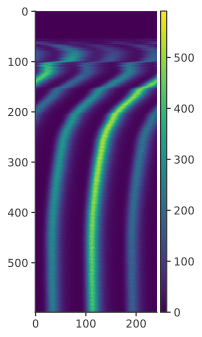

In [9]:
# plt.imshow(data_d.results[0].hist_2d_1)

# afine_tf = tf.AffineTransform(shear=(0.0,0.2))



# afine_tf = tf.AffineTransform(
#     np.array([[1, 0, 0], [-angle, 1, 0], [0, 0, 1]]))
# # Apply transform to image data
# modified = tf.warp(data_d.results[0].hist_2d_2, inverse_map=afine_tf)
# 244.5558
# 500 ps
print(np.max(data_d.results[0].hist_2d_2))
io.imshow(data_d.results[0].hist_2d_2)
io.show()



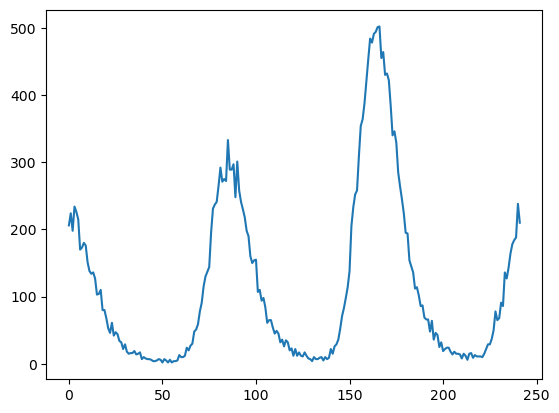

In [36]:
plt.plot(modified[200])

In [21]:
kernel = np.average(modified[-20:],axis=0)

c:\Users\Andrew\mambaforge\envs\research11\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


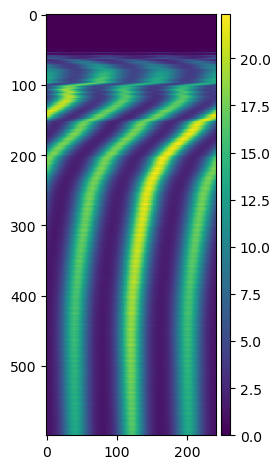

In [40]:
res = correlate1d(modified/np.max(modified), weights=kernel/np.max(kernel), axis=1, mode='wrap')
io.imshow(res)

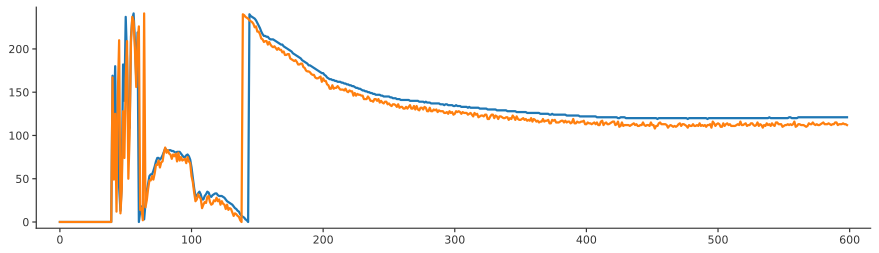

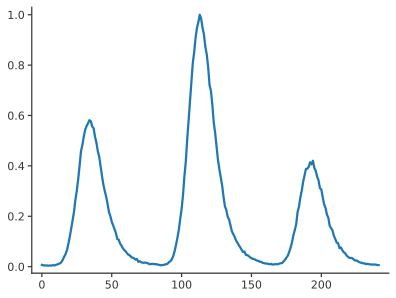

In [51]:
plt.plot(kernel)

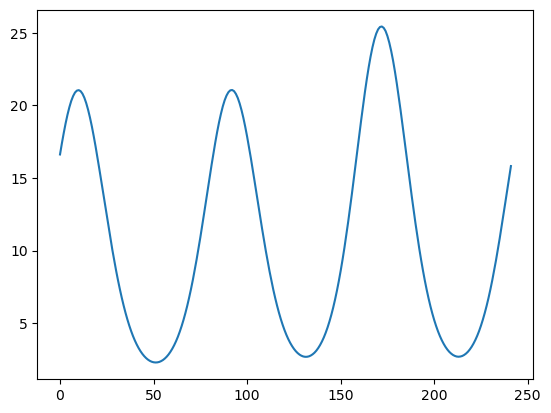

In [39]:
plt.plot(correlate(modified[200]/np.max(modified[200]), weights=kernel/np.max(kernel), mode='wrap'))

In [50]:
kernel = kernel/np.max(kernel)

c:\Users\Andrew\mambaforge\envs\research11\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


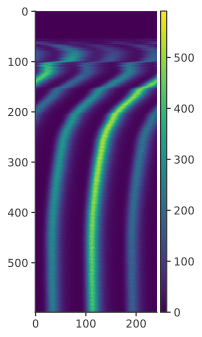

In [58]:
io.imshow(modified)

In [10]:


test = np.zeros(243)
    
# for offset in range(0,242):
#     test[offset] = np.nansum(np.abs(np.roll(kernel, offset) - (modified[200]/np.max(modified[200]))))

# modified = np.roll(modified, 100, axis=1)

@njit
def sum_absolut_differences(input_array, kernel):
    offset_off = 0
    old_offset = -1

    offsets = np.zeros(np.shape(input_array)[0])
    new  = np.zeros(np.shape(input_array))
    for i, row in enumerate(input_array):
        for of in range(0,np.shape(input_array)[1]):
            new[i,of] = np.nansum(np.abs(np.roll(kernel, of) - (row/np.max(row))))

        
        offset = np.argmin(new[i])
        
        if old_offset == -1:
            old_offset = offset

        # these handle period jumps
        if (offset - old_offset) > 240:
            offset_off = offset_off - 243

        if (offset - old_offset) < -240:
            offset_off = offset_off + 243
        
        offsets[i] = offset + offset_off
            

        old_offset = offset

    return new, offsets

# new1, offsets_1 = sum_absolut_differences(data_d.results[0].hist_2d_2, kernel)
# new2, offsets_2 = sum_absolut_differences(data_d.results[0].hist_2d_1, kernel)



def skew_and_kernel(hist_array, hist_period, hist_bins, delta_t_prime):

    angle = math.atan((hist_period/hist_bins)/delta_t_prime)
    # print(angle)
    afine_tf = tf.AffineTransform(
    np.array([[1, 0, 0], [-angle, 1, 0], [0, 0, 1]]))
    # Apply transform to image data
    modified = tf.warp(hist_array, inverse_map=afine_tf)

    kernel = np.average(modified[-20:],axis=0)
    kernel = kernel/np.max(kernel)

    correlated_array, offsets = sum_absolut_differences(modified, kernel)

    return correlated_array, offsets


arr1, offsets1 = skew_and_kernel(data_d.results[0].hist_2d_1, 244.5558, 243, 500)
arr2, offsets2 = skew_and_kernel(data_d.results[0].hist_2d_2, 244.5558, 243, 500)



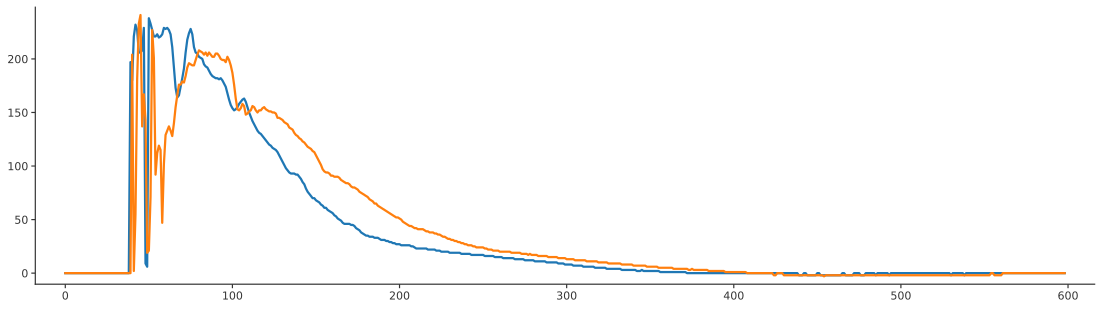

In [11]:
fig, ax = plt.subplots(1,1,figsize=(19,5))
ax.plot(offsets1)
ax.plot(offsets2)

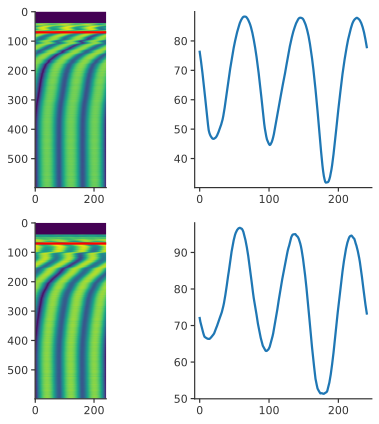

In [12]:
slice = 70

fig, ax = plt.subplots(2,2,figsize=(7,7))
# plt.plot(np.argmax(res,axis=1))
ax[0][0].imshow(arr1)
ax[0][0].axhline(slice, color='r')
ax[0][1].plot(arr1[slice])


ax[1][0].imshow(arr2)
ax[1][0].axhline(slice, color='r')
ax[1][1].plot(arr2[slice])




(599, 242)


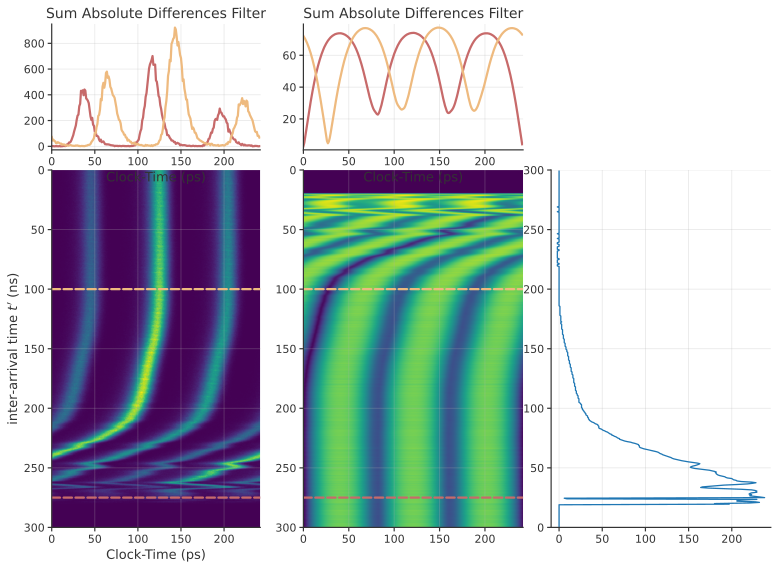

In [131]:
import matplotlib.ticker as ticker

fig =  plt.figure(figsize=(10,7))

vert_ratio = 0.32
spacing = 0.06

top, bottom = bisect([0,0,1,1], direction="horiz", offset=0.73, spacing=0.04)

left, pre_middle = bisect(top, direction="vert", offset=vert_ratio, spacing=spacing)
middle, right = bisect(pre_middle, direction="vert", offset=0.5, spacing=spacing)

left_bottom, pre_middle_bottom = bisect(bottom, direction="vert", offset=vert_ratio, spacing=spacing)
middle_bottom, right_bottom = bisect(pre_middle_bottom, direction="vert", offset=0.5, spacing=spacing)

left_fig = fig.add_axes(left)
middle_fig = fig.add_axes(middle)
right_fig = fig.add_axes(right)

slices_2d = fig.add_axes(left_bottom)
slices_filter = fig.add_axes(middle_bottom)
# right_bottom_fig = fig.add_axes(right_bottom)

def fill_regular_2d_hist(ax, data):
    ax.imshow(np.flip(data), aspect='auto', cmap='viridis', extent=[0,242,300,0])
    print(np.shape(data))
    # ax.set_title("2D Histogram")
    ax.set_xlabel("Clock-Time (ps)")
    ax.set_ylabel(r"inter-arrival time $t'$ (ns)")

    
def fill_absolute_differences(ax, data):
    
    ax.imshow(data, aspect='auto', cmap='viridis', extent=[0,242,300,0])

def fill_lower_hist(ax, data, ln, line_ax=None, color="black"):
    # ax.set_title("Sum Absolute Differences Filter")
    d = data[ln]
    ax.plot(d, color=color)
    if line_ax is not None:
        line_ax.axhline(y=300+ln/2, color=color, linestyle='--')

    ax.set_xlabel("Clock-Time (ps)")
    ax.set_xlim(0,242)

def fill_offsets_plot(ax, data):
    # ax.plot(np.arange(0,300, 0.5), data)
    ax.plot(data, np.arange(0,300, 0.5)[:-1], lw=1.3)
    ax.set_ylim(0,300)
    # ax.set_xlim(0,242)


fill_regular_2d_hist(left_fig, data_d.results[0].hist_2d_1)
fill_absolute_differences(middle_fig, arr1)

fill_lower_hist(slices_2d, data_d.results[0].hist_2d_1, ln = -50, line_ax=left_fig, color=Colors["red"])
fill_lower_hist(slices_2d, data_d.results[0].hist_2d_1, ln = -400, line_ax=left_fig, color=Colors["light_orange"])

fill_lower_hist(slices_filter, arr1, ln=-50, line_ax=middle_fig, color=Colors["red"])
fill_lower_hist(slices_filter, arr1, ln=-400, line_ax=middle_fig, color=Colors["light_orange"])


fill_offsets_plot(right_fig, offsets1)

